### Small Worlds and Large Worlds

In [5]:
# Core
import numpy as np
import arviz as az
import tensorflow as tf
import tensorflow_probability as tfp
import scipy.stats as stats

# visualization
import matplotlib.pyplot as plt

# aliases
tfd = tfp.distributions

In [9]:
#!pip install watermark

In [10]:
#!pip install arviz

In [7]:
%load_ext watermark

In [8]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas

numpy                 : 1.19.5
tensorflow            : 2.6.0
tensorflow_probability: 0.14.1
arviz                 : 0.11.4
scipy                 : 1.7.1
pandas                : 1.3.4



**Code 2.1**

In [11]:
ways = tf.constant([0.0, 3, 8, 9, 0])
new_ways = ways / tf.reduce_sum(ways)

new_ways

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0.  , 0.15, 0.4 , 0.45, 0.  ], dtype=float32)>

**Code 2.2**

In [13]:
tfd.Binomial(total_count=9, probs=0.5).prob(6)

<tf.Tensor: shape=(), dtype=float32, numpy=0.16406271>

In [14]:
# To make it more numerically stable:
tf.exp(tfd.Binomial(total_count=9, probs=0.5).log_prob(6))

<tf.Tensor: shape=(), dtype=float32, numpy=0.16406271>

**Code 2.3**: Grid approximation

In [15]:
# define grid
n_points = 20  # change to an odd number for Code 2.5 graphs to

# match book examples in Figure 2.6
p_grid = tf.linspace(start=0.0, stop=1.0, num=n_points)

# define prior
prior = tf.ones([n_points])

# compute likelihood at each value in grid
likelihood = tfd.Binomial(total_count=9, probs=p_grid).prob(6)

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / tf.reduce_sum(unstd_posterior)

posterior

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0.00000000e+00, 7.98985070e-07, 4.30771506e-05, 4.09079599e-04,
       1.89388776e-03, 5.87387430e-03, 1.40429335e-02, 2.78517473e-02,
       4.78011481e-02, 7.28073865e-02, 9.98729616e-02, 1.24264337e-01,
       1.40314296e-01, 1.42834902e-01, 1.28943339e-01, 9.98729020e-02,
       6.20589107e-02, 2.64547672e-02, 4.65966808e-03, 0.00000000e+00],
      dtype=float32)>

**Code 2.4**

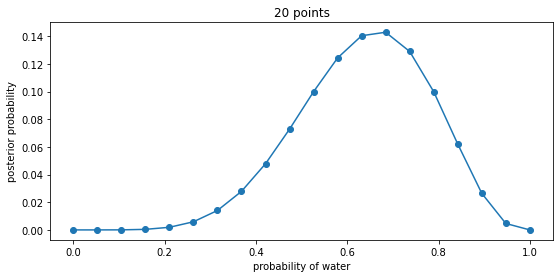

In [16]:
_, ax = plt.subplots(figsize=(9, 4))
ax.plot(p_grid, posterior, "-o")
ax.set(xlabel="probability of water", ylabel="posterior probability", title="20 points");

**Code 2.5**

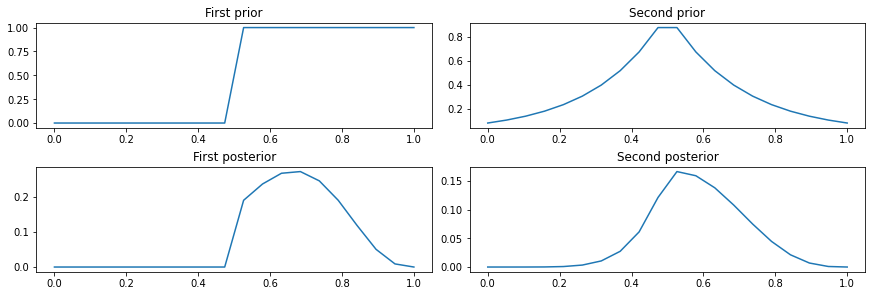

In [17]:
first_prior = tf.where(condition=p_grid < 0.5, x=0.0, y=1)
second_prior = tf.exp(-5 * abs(p_grid - 0.5))

_, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 4), constrained_layout=True)

axes[0, 0].plot(p_grid, first_prior)
axes[0, 0].set_title("First prior")
axes[1, 0].plot(p_grid, first_prior * likelihood)
axes[1, 0].set_title("First posterior")

axes[0, 1].plot(p_grid, second_prior)
axes[0, 1].set_title("Second prior")
axes[1, 1].plot(p_grid, second_prior * likelihood)
axes[1, 1].set_title("Second posterior");

**Code 2.6**: Quadratic approximation

TFP doesn't natively provide a quap function, like in the book. But it has a lot of optimization tools. We'll use bfgs, which gives us a somewhat straightforward way to get both the measurement and the standard error.

In [18]:
W = 6
L = 3
dist = tfd.JointDistributionNamed(
    {
        "water": lambda probability: tfd.Binomial(total_count=W + L, probs=probability),
        "probability": tfd.Uniform(low=0.0, high=1.0),
    }
)


def neg_log_prob(x):
    return tfp.math.value_and_gradient(
        lambda p: -dist.log_prob(
            water=W, probability=tf.clip_by_value(p[-1], 0.0, 1.0)
        ),
        x,
    )

results = tfp.optimizer.bfgs_minimize(neg_log_prob, initial_position=[0.5])
assert results.converged

The results object itself has a lot of information about the optimization process. The estimate is called the position, and we get the standard error from the inverse_hessian_estimate.

In [19]:
approximate_posterior = tfd.Normal(
    results.position,
    tf.sqrt(results.inverse_hessian_estimate),
)

print(
    "mean:",
    approximate_posterior.mean(),
    "\nstandard deviation: ",
    approximate_posterior.stddev(),
)

mean: tf.Tensor([[0.6666667]], shape=(1, 1), dtype=float32) 
standard deviation:  tf.Tensor([[0.14433758]], shape=(1, 1), dtype=float32)


**Code 2.7**: Analytical solution

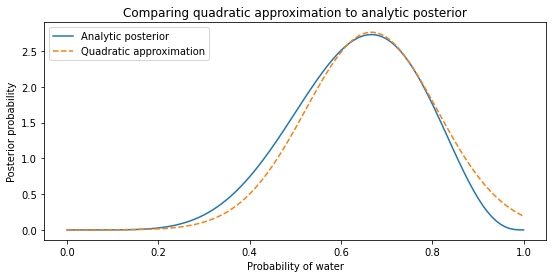

In [21]:
_, ax = plt.subplots(figsize=(9, 4))

x = tf.linspace(0.0, 1.0, num=101)
ax.plot(x, tfd.Beta(W + 1, L + 1).prob(x), label="Analytic posterior")
# values obained from quadratic approximation
ax.plot(
    x, tf.squeeze(approximate_posterior.prob(x)), "--", label="Quadratic approximation"
)

ax.set(
    xlabel="Probability of water",
    ylabel="Posterior probability",
    title="Comparing quadratic approximation to analytic posterior",
)
ax.legend();

**Code 2.8**: Markov Chain MonteCarlo

In [22]:
n_samples = 1000
p = np.zeros(n_samples)
p[0] = 0.5
W = 6
L = 3
for i in range(1, n_samples):
    p_new = tfd.Normal(loc=p[i - 1], scale=0.1).sample(1)
    if p_new < 0:
        p_new = p_new
    if p_new > 1:
        p_new = 2 - p_new
    q0 = tf.exp(tfd.Binomial(total_count=W + L, probs=p[i - 1]).log_prob(W))
    q1 = tf.exp(tfd.Binomial(total_count=W + L, probs=p_new).log_prob(W))
    if stats.uniform.rvs(0, 1) < q1 / q0:
        p[i] = p_new
    else:
        p[i] = p[i - 1]

**Code 2.9**

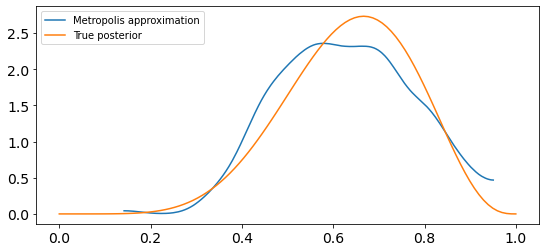

In [23]:
_, ax = plt.subplots(figsize=(9, 4))

az.plot_kde(p, label="Metropolis approximation", ax=ax)
x = tf.linspace(0.0, 1.0, num=100)
ax.plot(x, tfd.Beta(W + 1, L + 1).prob(x), "C1", label="True posterior")
ax.legend();